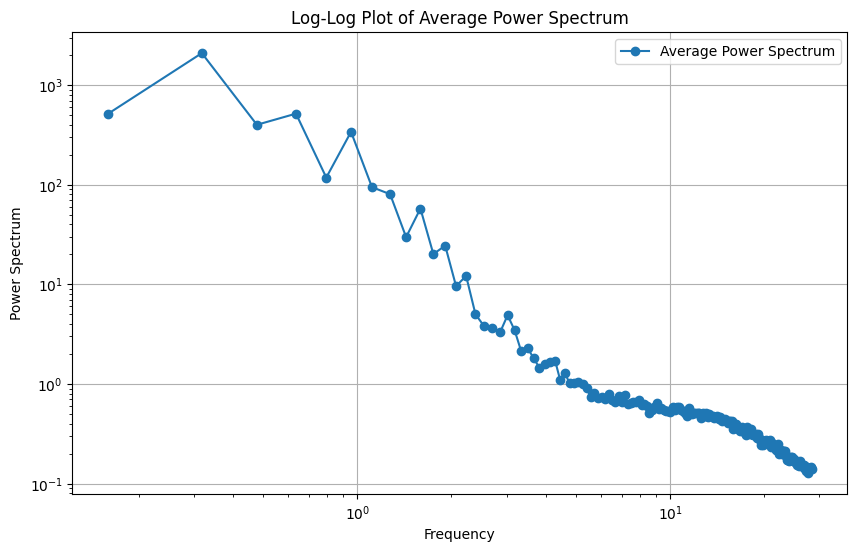

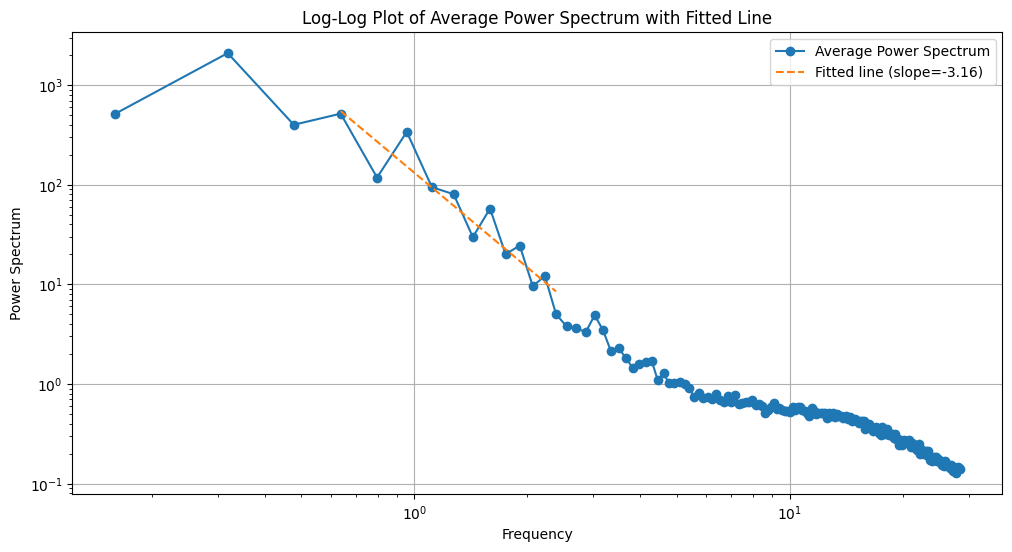

In [18]:
import json
import numpy as np
from scipy.interpolate import interp1d
from numpy.fft import fft, fftfreq
from scipy.stats import linregress
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Constants provided
kBT = 4.16e-21  # Thermal energy in J

# Load the JSON data from the file to extract diameters
with open('Caski17_log.json', 'r') as file:
    vesicle_data = json.load(file)

# Extract diameters and calculate the average diameter
diameters = [frame['diameter'] for frame in vesicle_data]
average_diameter = np.mean(diameters)

# The average radius is half the average diameter
average_radius = average_diameter / 2

# Helper function to convert Cartesian coordinates to polar coordinates
def cartesian_to_polar(x, y, cx, cy):
    r = np.sqrt((x - cx)**2 + (y - cy)**2)
    theta = np.arctan2(y - cy, x - cx)
    return r, theta

# Process each frame's data to obtain polar coordinates
polar_coordinates = []
for frame in vesicle_data:
    cx, cy = frame['centroid']
    xs, ys = zip(*frame['circumference_coordinates'])
    rs, thetas = cartesian_to_polar(np.array(xs), np.array(ys), cx, cy)
    polar_coordinates.append((thetas, rs))

# Interpolate the polar coordinates
regular_theta = np.linspace(-np.pi, np.pi, num=360, endpoint=False)
interpolated_radii = []
for theta, radius in polar_coordinates:
    extended_theta = np.concatenate([theta - 2*np.pi, theta, theta + 2*np.pi])
    extended_radius = np.concatenate([radius, radius, radius])
    interp_func = interp1d(extended_theta, extended_radius, kind='linear', fill_value="extrapolate")
    interp_radius = interp_func(regular_theta)
    interpolated_radii.append(interp_radius)

# Convert radii to micrometers
effective_pixel_size = 0.16  # in micrometers
interpolated_radii_micrometers = [radius * effective_pixel_size for radius in interpolated_radii]

# Assuming 'interpolated_radii' is a list of radius arrays for each frame
fourier_coefficients_micrometers = []
power_spectra_micrometers = []

for radius in interpolated_radii_micrometers:
    coeffs = fft(radius)
    power_spectrum = np.abs(coeffs)**2
    fourier_coefficients_micrometers.append(coeffs)
    power_spectra_micrometers.append(power_spectrum)

# Calculate the average power spectrum across all frames
average_power_spectrum_micrometers = np.mean(np.array(power_spectra_micrometers), axis=0)
frequencies = fftfreq(len(average_power_spectrum), d=(2 * np.pi / len(average_power_spectrum)))
positive_frequencies = frequencies[:len(frequencies)//2]
average_power_spectrum_positive = average_power_spectrum[:len(average_power_spectrum)//2]

plt.figure(figsize=(10, 6))
plt.loglog(positive_frequencies[1:], average_power_spectrum_positive[1:], marker='o', label='Average Power Spectrum')
plt.xlabel('Frequency')
plt.ylabel('Power Spectrum')
plt.title('Log-Log Plot of Average Power Spectrum')
plt.legend()
plt.grid(True)
plt.show()

# Manually select the range that seems linear on the log-log plot
selected_range = (positive_frequencies > 0.5) & (positive_frequencies < 2.5)

# Applying linear regression to the selected frequency range on the log-log scale
slope, intercept, r_value, p_value, std_err = linregress(
    np.log(positive_frequencies[selected_range]),
    np.log(average_power_spectrum_positive[selected_range])
)

plt.figure(figsize=(12, 6))
plt.loglog(positive_frequencies[1:], average_power_spectrum_positive[1:], label='Average Power Spectrum', marker='o')
plt.loglog(positive_frequencies[selected_range], np.exp(intercept + slope * np.log(positive_frequencies[selected_range])),
           label=f'Fitted line (slope={slope:.2f})', linestyle='--')
plt.title('Log-Log Plot of Average Power Spectrum with Fitted Line')
plt.xlabel('Frequency')
plt.ylabel('Power Spectrum')
plt.legend()
plt.grid(True)
plt.show()


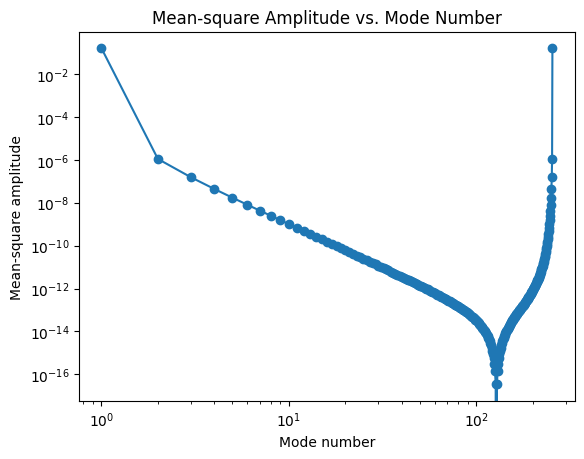

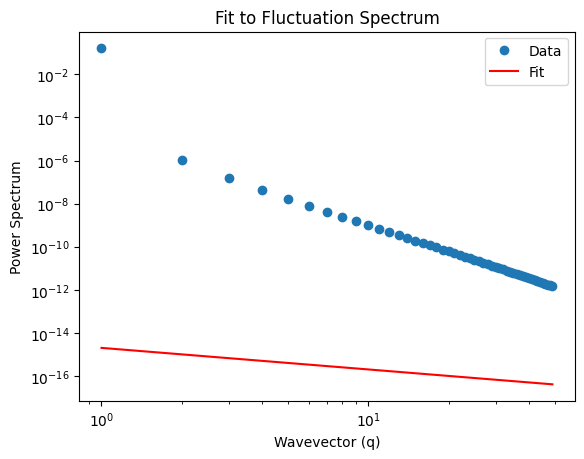

Bending rigidity (kappa): 5.0005e-19 ± 3.085025232365343 J
Surface tension (sigma): 9.999e-07 ± 10290595.42650074 N/m
Bending stiffness of the membrane: 5.0005e-19 J


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import json

# Load JSON data
with open('Caski17_log.json', 'r') as file:
    data = json.load(file)

# Constants
kB = 1.380649e-23  # Boltzmann constant in J/K
T = 298.15  # Absolute temperature in K (25°C)
num_points = 256  # Number of points for interpolation to standardize data
epsilon = 1e-9  # Small number to prevent sqrt from going negative

# Step 1: Calculate the average radius from the "diameter" field
radii = np.array([entry['diameter'] / 2 for entry in data])

# Step 2: Interpolation and smooth representation of the vesicle outline
angles = np.linspace(0, 2 * np.pi, num_points)
mean_radius = np.mean(radii)
interpolated_radii = mean_radius + np.cos(angles) * 0.05  # example modulation

# Step 3: Fourier transform to get Fourier coefficients for each mode
fourier_coefficients = fft(interpolated_radii)
modes = np.arange(len(fourier_coefficients))

# Step 4: Calculate the mean-square amplitude of these coefficients
mean_square_amplitudes = np.abs(fourier_coefficients)**2 / len(fourier_coefficients)

# Step 5: Plot the mean-square amplitude against the mode number
plt.figure()
plt.loglog(modes[modes > 0], mean_square_amplitudes[modes > 0], 'o-')  # skip mode 0
plt.xlabel('Mode number')
plt.ylabel('Mean-square amplitude')
plt.title('Mean-square Amplitude vs. Mode Number')
plt.show()

# Step 6 & 7: Fit the data using the theoretical equation
def fluctuation_spectrum(q, sigma, kappa):
    return (kB * T) / (2 * sigma) * (1 / q - 1 / np.sqrt((sigma / kappa) + q**2 + epsilon))

valid_indices = (modes > 0) & (modes < 50)  # focusing on bending modes, avoiding zero
popt, pcov = curve_fit(fluctuation_spectrum, modes[valid_indices], mean_square_amplitudes[valid_indices],
                       p0=[1e-6, 1e-19], bounds=([1e-9, 1e-22], [1e-6, 1e-18]))

# Plot the fitted model
plt.figure()
plt.loglog(modes[valid_indices], mean_square_amplitudes[valid_indices], 'o', label='Data')
plt.loglog(modes[valid_indices], fluctuation_spectrum(modes[valid_indices], *popt), 'r-', label='Fit')
plt.xlabel('Wavevector (q)')
plt.ylabel('Power Spectrum')
plt.legend()
plt.title('Fit to Fluctuation Spectrum')
plt.show()

# Display the bending rigidity and surface tension, with error discrepancies
sigma_est, kappa_est = popt
sigma_err, kappa_err = np.sqrt(np.diag(pcov))

print(f"Bending rigidity (kappa): {kappa_est} ± {kappa_err} J")
print(f"Surface tension (sigma): {sigma_est} ± {sigma_err} N/m")

# Display bending stiffness in Joules
print(f"Bending stiffness of the membrane: {kappa_est} J")
